3 440.18239601600004 4


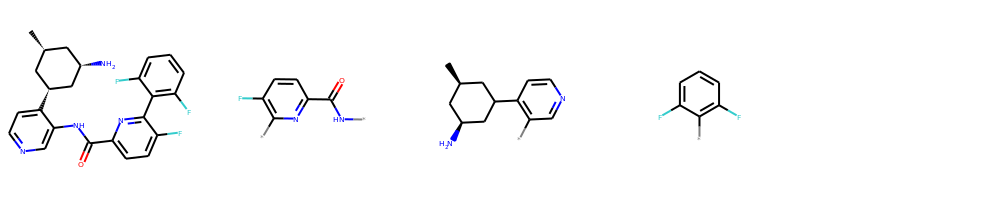

In [3]:
# load dependencies
import os
import re
import json
import shutil
import tempfile
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcNumAtomStereoCenters, CalcNumRotatableBonds


SH_dir = "~/.../RuSH"

# if not unique and overwrite, will delete the previous results of the same name!
ligand = "pim447"
job_id = "SF"
ligand_sdf = f'{SH_dir}/data/references/{ligand}.sdf'


job_name = f"LI_RL_{ligand}_{job_id}"

epochs = 1000
allowance=0.95

# --------- change these path variables as required
reinvent_dir = os.path.expanduser("~/repos/Reinvent")
reinvent_env = os.path.expanduser("~/anaconda3/envs/reinvent.v3.2")
output_dir = os.path.expanduser(f"~/.../LI/results/{job_name}")

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
overwrite = True
try:
    os.mkdir(output_dir)
except FileExistsError:
    if overwrite:
        shutil.rmtree(output_dir)
        os.mkdir(output_dir)
    else:
        pass



pim447_fragments = [
    "C(*)1=C(C2C[C@H](C)C[C@H](N)C2)C=CN=C1",
    "Fc1c([H])c([H])c([H])c(F)c(*)1",
]
aha006_fragments = [
    "C1=CC=C(O*)C=C1",
    "C1=CC=C(O*)C=C1",
    "C1=CC=C(*)C=C1",
    "C1=CC=C(*)C=C1",
]
sr3737_fragments = [
    "COC1=CC(NC(C2=CC=CC(*)=C2)=O)=CC(OC)=C1OC",
    "N(*)C1=C(F)C=CC=C1",
]
lre001_fragments = [
    "Nc1nc(*)cc(Cl)n1",
    "c(*)1sccc1",
]
warheads = ["|".join(pim447_fragments)]

def draw_smiles(smiles, names=None):
    def to_mol(smi):
        return Chem.MolFromSmiles(smi)
    if names:   
        return Draw.MolsToGridImage([to_mol(s) for s in smiles], molsPerRow=5,subImgSize=(200,200),
                                    legends=names)
    else:
        return Draw.MolsToGridImage([to_mol(s) for s in smiles], molsPerRow=5,subImgSize=(200,200))
    
# PDB 5IV4
# human soluble adenylyl cyclase in complex with the allosteric inhibitor LRE1

seeds = ["O=C(c1c([H])c([H])c(F)[c@@]([c@@]2c(F)c([H])c([H])c([H])c2F)n1)N(c3c([H])nc([H])c([H])c3[C@@]4([H])C([H])([H])[C@](N([H])[H])([H])C([H])([H])[C@@](C4([H])[H])([H])C([H])([H])[H])[H]"] 
# pim447

# methoxy fragments first
seeds_fragments = [("C(*)1=C(C2C[C@H](C)C[C@H](N)C2)C=CN=C1", "Fc1c([H])c([H])c([H])c(F)c(*)1"),]

seeds_linkers = [ "O=C(N[*])c1nc([*])c(F)cc1" ]


i = 0
mol = Chem.MolFromSmiles(seeds[i])
print(CalcNumAtomStereoCenters(mol),CalcExactMolWt(mol),CalcNumRotatableBonds(mol)) 

draw_smiles([seeds[i], seeds_linkers[i], seeds_fragments[i][0], seeds_fragments[i][1]])

In [4]:
# initialize the dictionary
configuration = {
    "version": 3,
    "model_type": "link_invent",
    "run_type": "reinforcement_learning"
}

In [5]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "",                          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir, "progress.log"),  # load this folder in tensorboard to 
                                                               # visualize training progress
    "result_folder": os.path.join(output_dir, "results"),      # output directory for results
    "job_name": job_name,     # set an arbitrary job name for identification
    "job_id": job_id                        # only relevant if "recipient" is set to "remote"
}

### 3. Parameters Block

This block specifies all the experiment parameters. In the cell below, we first set the hyperparameters for `Reinforcement Learning (RL)`, including:

1. `"actor" and "critic"`: These are the paths to a pre-trained `Link-INVENT` generative model. One such model is provided in the /models folder in this repository and named `linkinvent.prior`. This prior is the generative model featured in the `Link-INVENT` manuscript and all details related to its training can be found in the `Supporting Information`. Generally, the `"actor"` and `"critic"` are initialized as the same pre-trained model. 


2. `"warheads"`: This is a list specifiying the 2 molecular sub-units (as SMILES) to link. The `"*"` denotes the attachment point position of each warhead and the warheads are separated using the `"|"` delimiter.


3. `"n_steps"`: This denotes how many epochs to run `Link-INVENT`. Typically this can be set to between 100-200. In the example below, 20 is used for the `Illustrative Example` as the objective is relatively simple and thus, the agent learns to generate linkers that satisfy the desired objective quickly.


4. `"learning_rate"`: This denotes the learning rate. Generally, the default 0.0001 works well.


5. `"batch_size"`: The number of linkers to generate per epoch. Generally, the default 128 works well.


6. `"randomize_warhead"`: Denotes whether to obtain a randomized SMILES representation of the warheads at every epoch. Generally, the default "true" works well. Randomizing SMILES increases the generalizability (results may cover a larger `chemical space`).

7. `"learning_strategy"`: This denotes how the `loss function` is constructed. The default `"dap"` strategy and `"sigma" = 120 ` works well. For more information, see the `Link-INVENT` and `Lib-INVENT` manuscripts.

In [6]:
# add the "parameters" block
configuration["parameters"] = {}

configuration["parameters"] = {
    "actor": os.path.join(ipynb_path, "models/linkinvent.prior"),   # this pre-trained prior is provided in /models
    "critic": os.path.join(ipynb_path, "models/linkinvent.prior"),
    "warheads" : warheads,
    "n_steps": epochs,   # number of epochs to run Link-INVENT
    "learning_rate": 0.0001,   # the default value works well but can be increased depending on training progress
    "batch_size": 128,   # the default value works well
    "randomize_warheads": True,
    "learning_strategy": {
        "name": "dap", 
        "parameters": {
        "sigma": 120
        }
    }
}

#### Configure the scoring strategy
This includes setting up the `Diversity Filters` (discussed below) and the `Scoring Function` (discussed below).

In [7]:
configuration["parameters"]["scoring_strategy"] = {
    "name": "link_invent" # do not change
}

##### Configure Diversity Filter

The Diversity Filter (DF) offers users the control over agent `exploration` (generating molecules from different `chemical space`) and `exploitation` (generating favourable molecules from similar `chemical space`). There are 3 DFs available in `Link-INVENT`:


1. `"IdenticalMurckoScaffold"`: Penalizes repeated sampling of the same Bemis-Murcko scaffold. An important point to note here is that this effectively operates at the linker level since the 2 warheads are held constant. Thus, this DF ensures diverse linkers are generated.


2. `"NoFilterWithPenalty"`: Penalizes repeated sampling of the same linker. The corresponding linker receives a score scaled by 0.5 (halved).


3. `"NoFilter"`: No penalization.

The notion of "repeated sampling" is governed by the `"bucket_size"` parameter. This denotes the maximum number of permitted linkers corresponding to the choice of DF used. Further sampling of the linker will be penalized. For example, if a linker Bemis-Murcko scaffold (denote it scaffold A) has been sampled 25 times using a `"bucket_size"` of 25, the 26th time scaffold A is sampled, the linker receives a score of 0. This in turn encourages the agent to explore other `chemical space`.

Additional parameters include:


1. `"minscore"`: Denotes the mininum score a linker (and the corresponding linked molecules) must achieve to be saved in the final output (`scaffold memory`). In practice, this can be set to 0.4 so that only linkers that at least moderately satisfy the desired objective is saved. If set to 0, every single linker generated will be saved. This could be useful if one is interested in analyizing the overall sampling behaviour of the agent.


2. `"minsimilarity"`: If using the `"IdenticalMurckoScaffold"`, repeated sampling of the same Bemis-Murcko scaffold is penalized (as explained above). When a new Bemis-Murcko scaffold is generated by the agent, its similarity is compared to all the Bemis-Murcko scaffolds generated thus far. If there has already been a Bemis-Murcko scaffold sampled that possesses a similarity >= `"minsimilarity"`, the new Bemis-Murcko scaffold will populate that `bucket`. For example, consider a Bemis-Murcko scaffold A is sampled 24 times with a `"bucket_size"` of 25. Now consider a new (never seen before) Bemis-Murcko scaffold B is sampled. If B >= `"minsimilarity"`, then B will be added to the `bucket` of A. Subsequently, the next A or B sampled will result in 26 items in the bucket and would thus receive a score of 0 (penalization). This parameter can encourage more `exploration`.

In [8]:
configuration["parameters"]["scoring_strategy"]["diversity_filter"] =  {
      "bucket_size": 30,
      "minscore": 0.4,
      "minsimilarity": 0.4,
      "name": "IdenticalMurckoScaffold"   
}

##### Scoring Function Definition
The Scoring Function is the reward function used to assess the *desirability* of molecules generated by `Link-INVENT` via `RL`. An arbitrary number of components (as long as it is supported in the codebase) can be specified in the Scoring Function. Subsequently, the agent gradually learns to generate molecules that satisfy all desired objectives. 

An important consideration is that different components can have different ranges of raw values. These values are normalized in the interval $[0,1]$ such that the `Link-INVENT` agent can properly learn. Scores achieved by each component is aggregated to a `total score` desiring the overall *desirability* of the generated molecules. This is done either by the weighted average sum (`custom_sum`) or by a weighted geometric mean (`custom_product`). It is this `total score` that is used for the agent's policy update in the `RL` loop. For more details on `custom_sum` and `custom_product`, see the notebook in this repository: `Score_Transformations`.

We now discuss how raw component values are normalized in the interval $[0,1]$. A `score transformation` is applied that transforms the raw values based on the defined function. Tuning the parameters of the transformation function allows one to control the agent's learning, e.g., one may be interested in generating molecules with < 500 MW (arbitrary example). One could specify the transformation function to give maximum reward to molecules that are indeed < 500 MW and lower reward (or no reward) otherwise. See the notebook in this repository: `Score_Transformations` for more information. 

The Scoring Function components pertaining to the `Illustrative Example` presented in this notebook are specified in the below cell.

In [9]:
scoring_function = {
    "name": "custom_product", 
    "parallel": False,  # do not change                   
    
    "parameters": [
    {
        "component_type": "RuSHScore", 
        "name": "decoration conditioned distance and ROCS shape and color",   # arbitrary name for the component
        "weight": 1,                           # the weight of the component (default: 1)
        "specific_parameters": {
            'output_dir'  : output_dir,
            
            # the order of these molecules should be consistent.
            'database_from_smiles': False,
            'database_path'  : ligand_sdf, 
            "reference_smiles": list(zip(seeds, seeds_fragments, seeds_linkers)), 

            "partial_fragment_reward": 0.3,
            "allowance": allowance, # less strict fragments (azine was difficult to learn at 0.9)
            
            'oeomega_CA'  :'classic',           # see https://docs.eyesopen.com/applications/omega/omega/omega_opt_params.html
            'oeomega_rms' : 0.5,
            'n_conformers': 32,                # note exponential increase of compute time if not using a .db from file.
        
            'max_centers' : 6,    
            'max_molwt'   : 500,  
            'max_rotors'  : 10,   
            
            'ROCS_version': '2024',            # minor changes to fix bug
            'score_cutoff': 0.8,               # see https://docs.eyesopen.com/applications/rocs/rocs/rocs_opt_params.html
            'roc_maxconfs': 100,
            'roc_besthits': 500,
            'roc_timeout' : 1000, 
            
            'mcquery'     : True, # set these to False if you want to fetch individual conformer hits. 
            'nostructs'   : True, # not useful during RL, but can be handy if you want to visualize hits, analyse etc.

            'shape_weight': 1,     # does not reach 1 for exact smiles matches, and is always atleast somewhat positive (>0.2). 
            'color_weight': 1.2,   # consider adding more weight to color, as it scores generally much lower.
            'jacc_weight' : 1.5,
            'rocs_weight' : 1,
            'score_operator' : 'mean', 
            'num_cores': 10,          # be nice to the cpu and leave a few cores :)
      }
    } ]
}

configuration["parameters"]["scoring_strategy"]["scoring_function"] = scoring_function

The dictionary has now been initialized with all parameters necessary to run `Link-INVENT`. Next, we write it out as a `JSON` which will serve as the `Configuration JSON` to run `Link-INVENT`.

In [10]:
# write out the configuration to disc
configuration_JSON_path = os.path.join(output_dir, "Link-INVENT_Configuration.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=False)

The `Configuration JSON` is saved to the `output_dir` specified in the beginning of this notebook.

# Run
Execute `Link-INVENT` directly in this jupyter notebook

In [10]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!{reinvent_env}/bin/python {reinvent_dir}/input.py {configuration_JSON_path}

In [11]:
# print the output to a file, just to have it for documentation
with open(os.path.join(output_dir, "run.err"), 'w') as file:
    file.write(captured_err_stream.stdout)

Execute in command line
```
# activate environment
$ conda activate reinvent.v3.2

# execute in command line
$ python <reinvent_dir>/input.py <configuration_JSON_path>
```

## Analyse the results

In order to analyze the run in a more intuitive way, we can use `tensorboard`:

```
# go to the root folder of the output
$ cd <output_dir>

# activate the environment
$ conda activate reinvent.v3.2

# start tensorboard
$ tensorboard --logdir "progress.log"
```

Then copy the link provided to a browser window. The following figures are example plots - there is always some randomness involved. The `tensorboard` plots display both the individual scoring function components and the average overall score.

![](img/Link-INVENT_Training_Plots.png)
The 2 components in the scoring function, `linker number of hydrogen-bond donors` (which we want to limit in the `Illustrative Example`) and the `linker number of rings` (which we want to be exactly 1) are satisfied very quickly, as exemplified by the rapid score increase. The `Average score (total score)` plot is the aggregated score of the 2 components via the `custom product` (weighted geometric mean)
![](img/Link-INVENT_Training_Plots_2.png)
Valid SMILES are SMILES that follow correct chemical syntax (if it can be parsed by RDKit). Number of SMILES found shows SMILES with scores over 0.4 (or other `min_score` specified in the DF setup if required. **In this notebook, this was set to 0 so all SMILES generated were collected**).


## Scaffold Memory: where the top compounds generated are saved
All valid compounds with scores over 0.4 (**In this notebook, this was set to 0 so all SMILES generated were collected**) can be found in the `scaffold_memory.csv` file.The SMILES are ranked by their total scores from high to low. 

**note: scaffold_memory.csv contains SMILES, Scaffolds, Scores from different components and Total score.**

First, we show a few lines of the `scaffold_memory.csv`.

In [ ]:
# import needed packages
import pandas as pd

scaffold_memory_path = os.path.join(output_dir, 'results/scaffold_memory.csv')
df = pd.read_csv(scaffold_memory_path)
df.head()

Next, we show a few example molecules.

In [ ]:
# import needed packages
from rdkit import Chem
from rdkit.Chem import Draw

smile_list = df['SMILES'][:6].to_list() # change the number here to show more/less top compounds
mols = [Chem.MolFromSmiles(smiles) for smiles in smile_list]
Draw.MolsToGridImage(mols)